# 3.5 Strategy Comparison: Short, Long, and Combined

Compare three strategy types across multiple K values:
- **Short-only**: Short bottom-K ranked stocks
- **Long-only**: Long top-K ranked stocks  
- **Long-Short**: Long top-K and short bottom-K (market neutral)

Uses simple returns with ±100% clipping (realistic, no artificial limits).

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from dataclasses import dataclass

import torch
import torch.nn as nn
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Model Loading

In [2]:
@dataclass
class ModelConfig:
    n_fundamental_features: int = 19
    n_price_features: int = 9
    n_embedding_dim: int = 768
    fundamental_latent: int = 32
    price_latent: int = 16
    news_latent: int = 32
    fund_hidden: int = 64
    price_hidden: int = 32
    news_hidden: int = 128
    fundamental_dropout: float = 0.8
    price_dropout: float = 0.4
    news_dropout: float = 0.2
    news_alpha: float = 0.8


class MultiBranchRanker(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        fund_hidden = getattr(config, 'fund_hidden', 64)
        price_hidden = getattr(config, 'price_hidden', 32)
        news_hidden = getattr(config, 'news_hidden', 128)
        
        self.fund_encoder = nn.Sequential(
            nn.Linear(config.n_fundamental_features, fund_hidden),
            nn.ReLU(),
            nn.Dropout(config.fundamental_dropout),
            nn.Linear(fund_hidden, config.fundamental_latent),
            nn.ReLU(),
        )
        
        self.price_encoder = nn.Sequential(
            nn.Linear(config.n_price_features, price_hidden),
            nn.ReLU(),
            nn.Dropout(config.price_dropout),
            nn.Linear(price_hidden, config.price_latent),
            nn.ReLU(),
        )
        
        self.news_encoder = nn.Sequential(
            nn.Linear(config.n_embedding_dim, news_hidden),
            nn.ReLU(),
            nn.Dropout(config.news_dropout),
            nn.Linear(news_hidden, config.news_latent),
            nn.ReLU(),
        )
        
        fused_dim = config.fundamental_latent + config.price_latent + config.news_latent
        self.output_head = nn.Sequential(
            nn.Linear(fused_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1),
        )
    
    def forward(self, price, fund, emb):
        h_f = self.fund_encoder(fund)
        h_p = self.price_encoder(price)
        h_n = self.news_encoder(emb)
        h_n_scaled = self.config.news_alpha * h_n
        h = torch.cat([h_f, h_p, h_n_scaled], dim=-1)
        return self.output_head(h).squeeze(-1)


def load_model(path, device, default_config=None):
    path = Path(path)
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
        config = checkpoint.get("config", default_config or ModelConfig())
        print(f"Loaded checkpoint from {path}")
    else:
        state_dict = checkpoint
        config = default_config or ModelConfig()
        print(f"Loaded weights from {path}")
    
    model = MultiBranchRanker(config).to(device)
    model.load_state_dict(state_dict)
    model.eval()
    
    return model, config

## 2. Load Data

In [3]:
df = pd.read_parquet("data/ml_dataset.pqt")
df["feature_date"] = pd.to_datetime(df["feature_date"])

# Convert to simple returns and clip extremes
df["simple_return"] = np.exp(df["target_return"]) - 1
CLIP_LIMIT = 1.0  # ±100%
n_clipped = ((df["simple_return"] < -CLIP_LIMIT) | (df["simple_return"] > CLIP_LIMIT)).sum()
df["simple_return"] = df["simple_return"].clip(-CLIP_LIMIT, CLIP_LIMIT)

print(f"Dataset: {len(df):,} rows")
print(f"Clipped {n_clipped:,} extreme values ({n_clipped/len(df)*100:.3f}%)")
print(f"Return range: [{df['simple_return'].min():.3f}, {df['simple_return'].max():.3f}]")

Dataset: 2,092,929 rows
Clipped 81 extreme values (0.004%)
Return range: [-1.000, 1.000]


In [4]:
# Feature columns
price_feat_cols = [
    "overnight_gap_z", "intraday_ret_z",
    "ret_1d_z", "ret_2d_z", "ret_3d_z", "ret_5d_z",
    "vol_5d_z", "dist_from_high_5d_z", "dist_from_low_5d_z"
]
fund_feat_cols = [c for c in df.columns if c.endswith("_z") and c not in price_feat_cols and c != "news_count_z"]
emb_cols = [c for c in df.columns if c.startswith("emb_")]

print(f"Price features: {len(price_feat_cols)}")
print(f"Fundamental features: {len(fund_feat_cols)}")
print(f"Embedding dims: {len(emb_cols)}")

Price features: 9
Fundamental features: 19
Embedding dims: 768


In [5]:
# Time-based split - test set only
dates = sorted(df["feature_date"].unique())
n_dates = len(dates)
val_end_idx = int(n_dates * 0.8)

test_dates = set(dates[val_end_idx:])
test_df = df[df["feature_date"].isin(test_dates)].copy()

# News-only filter
has_news = (test_df[emb_cols].abs().sum(axis=1) > 0)
test_df_news = test_df[has_news].copy()

print(f"Test set: {len(test_df):,} rows, {len(test_dates)} days")
print(f"Test (news-only): {len(test_df_news):,} rows")
print(f"Date range: {min(test_dates).date()} to {max(test_dates).date()}")

Test set: 464,188 rows, 238 days
Test (news-only): 128,502 rows
Date range: 2024-10-22 to 2025-12-18


## 3. Load Model

In [6]:
# List available models
models = sorted(Path("data").glob("model*.pt"))
print("Available models:")
for m in models:
    print(f"  {m.name}")

Available models:
  model_best.pt
  model_best_26M_pairs_.pt
  model_best_all_pairs-best.pt
  model_best_all_pairs.pt
  model_best_all_pairs_.pt
  model_best_all_pairs_2.pt
  model_best_all_pairs_ep3.pt
  model_best_all_pairs_ep6.pt
  model_capped.pt
  model_dropout_optimized.pt
  model_final.pt
  model_final_full.pt
  model_hyperparam_optimized.pt
  model_robust_optimized.pt
  model_simple_returns.pt
  model_single_pair.pt
  model_single_pair_fixed.pt
  model_single_pair_sharpe10.pt
  model_single_pair_sharpe8.pt
  model_single_pair_sharpe9.pt


In [7]:
# Select model
MODEL_PATH = "data/model_robust_optimized.pt"

default_config = ModelConfig(
    n_fundamental_features=len(fund_feat_cols),
    n_price_features=len(price_feat_cols),
    n_embedding_dim=len(emb_cols),
)

model, config = load_model(MODEL_PATH, device, default_config)

Loaded checkpoint from data/model_robust_optimized.pt


## 4. Score Stocks

In [8]:
@torch.no_grad()
def score_dataframe(model, df, price_cols, fund_cols, emb_cols, device, batch_size=1024):
    model.eval()
    
    price_arr = torch.tensor(df[price_cols].values.astype(np.float32))
    fund_arr = torch.tensor(df[fund_cols].values.astype(np.float32))
    emb_arr = torch.tensor(df[emb_cols].values.astype(np.float32))
    
    scores = []
    for i in range(0, len(df), batch_size):
        price = price_arr[i:i+batch_size].to(device)
        fund = fund_arr[i:i+batch_size].to(device)
        emb = emb_arr[i:i+batch_size].to(device)
        score = model(price, fund, emb)
        scores.append(score.cpu().numpy())
    
    df_scored = df.copy()
    df_scored["score"] = np.concatenate(scores)
    
    return df_scored

In [9]:
test_scored = score_dataframe(model, test_df_news, price_feat_cols, fund_feat_cols, emb_cols, device)
print(f"Scored {len(test_scored):,} rows")
print(f"Score range: [{test_scored['score'].min():.3f}, {test_scored['score'].max():.3f}]")

Scored 128,502 rows
Score range: [-0.557, 0.195]


## 5. Strategy Functions

In [10]:
def compute_daily_return(df_day, k, strategy="short"):
    """
    Compute daily return for different strategies.
    
    Args:
        df_day: DataFrame for single day with 'score' and 'simple_return'
        k: Number of positions
        strategy: 'short', 'long', or 'long_short'
    
    Returns:
        (daily_return, n_positions)
    """
    if len(df_day) < k:
        return np.nan, 0
    
    if strategy == "short":
        # Short bottom-K (lowest scores)
        bottom_k = df_day.nsmallest(k, "score")
        # Short return = negative of actual return
        ret = -bottom_k["simple_return"].mean()
        return ret, len(bottom_k)
    
    elif strategy == "long":
        # Long top-K (highest scores)
        top_k = df_day.nlargest(k, "score")
        ret = top_k["simple_return"].mean()
        return ret, len(top_k)
    
    elif strategy == "long_short":
        # Long top-K and short bottom-K (market neutral)
        if len(df_day) < 2 * k:
            return np.nan, 0
        
        top_k = df_day.nlargest(k, "score")
        bottom_k = df_day.nsmallest(k, "score")
        
        # Equal weight: 50% long, 50% short
        long_ret = top_k["simple_return"].mean()
        short_ret = -bottom_k["simple_return"].mean()
        ret = (long_ret + short_ret) / 2
        
        return ret, 2 * k
    
    else:
        raise ValueError(f"Unknown strategy: {strategy}")


def run_strategy(df_scored, k, strategy="short"):
    """Run strategy across all dates."""
    results = []
    
    for date, df_day in df_scored.groupby("feature_date"):
        ret, n_pos = compute_daily_return(df_day, k, strategy)
        
        if not np.isnan(ret):
            results.append({
                "date": date,
                "return": ret,
                "n_positions": n_pos,
            })
    
    return pd.DataFrame(results)


def compute_metrics(results_df):
    """Compute performance metrics."""
    if len(results_df) < 2:
        return {"sharpe": 0, "total_return": 0, "mean_daily": 0, "std_daily": 0, "win_rate": 0, "n_days": 0}
    
    returns = results_df["return"]
    mean_ret = returns.mean()
    std_ret = returns.std()
    
    sharpe = mean_ret / std_ret * np.sqrt(252) if std_ret > 0 else 0
    total_return = (1 + returns).cumprod().iloc[-1] - 1
    win_rate = (returns > 0).mean()
    
    return {
        "sharpe": sharpe,
        "total_return": total_return,
        "mean_daily": mean_ret,
        "std_daily": std_ret,
        "win_rate": win_rate,
        "n_days": len(results_df),
    }

## 6. Run All Strategies

In [11]:
# Configuration
K_VALUES = [3, 5, 10, 15, 20]
STRATEGIES = ["short", "long", "long_short"]

print(f"Testing {len(K_VALUES)} K values x {len(STRATEGIES)} strategies = {len(K_VALUES) * len(STRATEGIES)} configs")

Testing 5 K values x 3 strategies = 15 configs


In [12]:
all_results = []

print("\nRUNNING STRATEGY COMPARISON")
print("=" * 90)
print(f"{'Strategy':<12} {'K':>3}  {'Sharpe':>8}  {'Return':>10}  {'Daily':>10}  {'WinRate':>8}  {'Days':>5}")
print("-" * 90)

for strategy in STRATEGIES:
    for k in K_VALUES:
        results_df = run_strategy(test_scored, k, strategy)
        metrics = compute_metrics(results_df)
        
        all_results.append({
            "strategy": strategy,
            "k": k,
            **metrics,
        })
        
        print(f"{strategy:<12} {k:>3}  {metrics['sharpe']:>8.2f}  {metrics['total_return']*100:>9.1f}%  "
              f"{metrics['mean_daily']*100:>9.3f}%  {metrics['win_rate']*100:>7.1f}%  {metrics['n_days']:>5}")
    print()

print("=" * 90)


RUNNING STRATEGY COMPARISON
Strategy       K    Sharpe      Return       Daily   WinRate   Days
------------------------------------------------------------------------------------------
short          3      3.02     3151.3%      2.230%     68.1%    238
short          5      2.69     1159.5%      1.456%     62.6%    238
short         10      2.47      453.4%      0.884%     60.1%    238
short         15      2.03      208.8%      0.577%     57.6%    238
short         20      1.90      151.0%      0.462%     58.4%    238

long           3     -0.12       -6.7%     -0.013%     50.8%    238
long           5      0.07       -1.1%      0.007%     47.5%    238
long          10      0.13        0.6%      0.011%     49.6%    238
long          15      0.06       -0.8%      0.004%     51.7%    238
long          20     -0.16       -4.6%     -0.013%     49.6%    238

long_short     3      3.01      806.9%      1.108%     67.2%    238
long_short     5      2.76      357.5%      0.731%     63.0%  

In [13]:
# Create results DataFrame
results_df = pd.DataFrame(all_results)
results_df["return_pct"] = results_df["total_return"] * 100

# Pivot table for easy comparison
print("\nSHARPE RATIO BY STRATEGY AND K")
print("=" * 50)
sharpe_pivot = results_df.pivot(index="k", columns="strategy", values="sharpe")
sharpe_pivot = sharpe_pivot[["short", "long", "long_short"]]
print(sharpe_pivot.round(2))

print("\nTOTAL RETURN (%) BY STRATEGY AND K")
print("=" * 50)
return_pivot = results_df.pivot(index="k", columns="strategy", values="return_pct")
return_pivot = return_pivot[["short", "long", "long_short"]]
print(return_pivot.round(1))


SHARPE RATIO BY STRATEGY AND K
strategy  short  long  long_short
k                                
3          3.02 -0.12        3.01
5          2.69  0.07        2.76
10         2.47  0.13        2.60
15         2.03  0.06        2.18
20         1.90 -0.16        2.01

TOTAL RETURN (%) BY STRATEGY AND K
strategy   short  long  long_short
k                                 
3         3151.3  -6.7       806.9
5         1159.5  -1.1       357.5
10         453.4   0.6       165.1
15         208.8  -0.8        89.3
20         151.0  -4.6        64.4


## 7. Visualizations

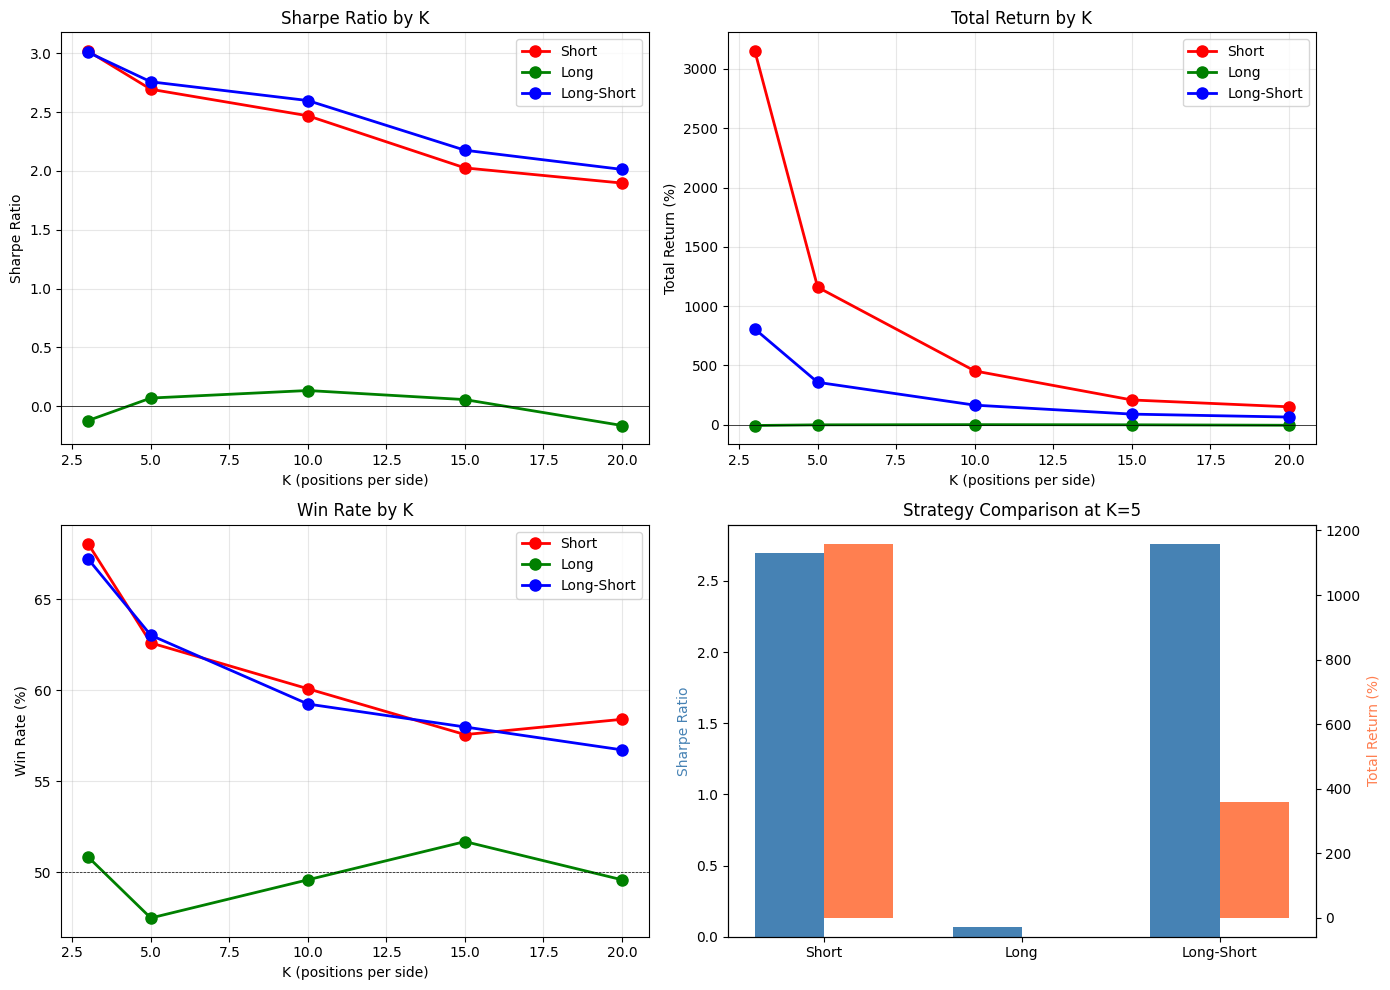

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {"short": "red", "long": "green", "long_short": "blue"}
labels = {"short": "Short", "long": "Long", "long_short": "Long-Short"}

# Sharpe by K
ax = axes[0, 0]
for strategy in STRATEGIES:
    subset = results_df[results_df["strategy"] == strategy]
    ax.plot(subset["k"], subset["sharpe"], "o-", color=colors[strategy], 
            label=labels[strategy], linewidth=2, markersize=8)
ax.set_xlabel("K (positions per side)")
ax.set_ylabel("Sharpe Ratio")
ax.set_title("Sharpe Ratio by K")
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linewidth=0.5)

# Total Return by K
ax = axes[0, 1]
for strategy in STRATEGIES:
    subset = results_df[results_df["strategy"] == strategy]
    ax.plot(subset["k"], subset["return_pct"], "o-", color=colors[strategy],
            label=labels[strategy], linewidth=2, markersize=8)
ax.set_xlabel("K (positions per side)")
ax.set_ylabel("Total Return (%)")
ax.set_title("Total Return by K")
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linewidth=0.5)

# Win Rate by K
ax = axes[1, 0]
for strategy in STRATEGIES:
    subset = results_df[results_df["strategy"] == strategy]
    ax.plot(subset["k"], subset["win_rate"] * 100, "o-", color=colors[strategy],
            label=labels[strategy], linewidth=2, markersize=8)
ax.set_xlabel("K (positions per side)")
ax.set_ylabel("Win Rate (%)")
ax.set_title("Win Rate by K")
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(50, color='black', linewidth=0.5, linestyle='--')

# Bar chart comparison at K=5
ax = axes[1, 1]
k5_results = results_df[results_df["k"] == 5]
x = np.arange(len(STRATEGIES))
width = 0.35

bars1 = ax.bar(x - width/2, k5_results["sharpe"], width, label="Sharpe", color="steelblue")
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, k5_results["return_pct"], width, label="Return %", color="coral")

ax.set_xticks(x)
ax.set_xticklabels([labels[s] for s in STRATEGIES])
ax.set_ylabel("Sharpe Ratio", color="steelblue")
ax2.set_ylabel("Total Return (%)", color="coral")
ax.set_title("Strategy Comparison at K=5")
ax.axhline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

## 8. Equity Curves

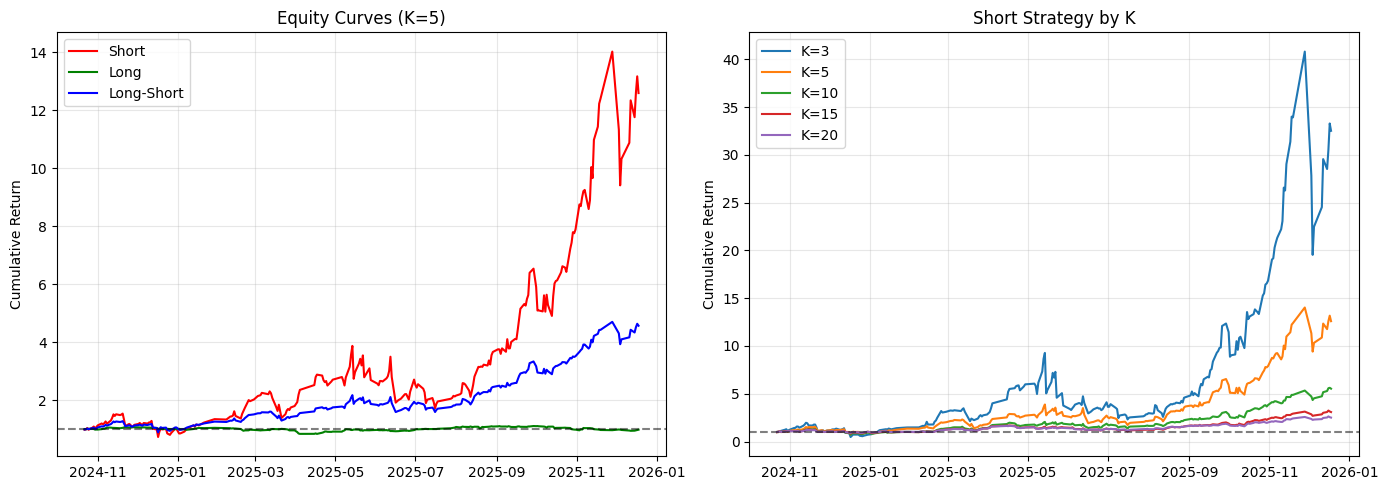

In [15]:
# Compare equity curves at K=5
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# K=5 comparison
ax = axes[0]
for strategy in STRATEGIES:
    strategy_results = run_strategy(test_scored, k=5, strategy=strategy)
    cumret = (1 + strategy_results["return"]).cumprod()
    ax.plot(strategy_results["date"], cumret, label=labels[strategy], 
            color=colors[strategy], linewidth=1.5)

ax.axhline(1, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel("Cumulative Return")
ax.set_title("Equity Curves (K=5)")
ax.legend()
ax.grid(True, alpha=0.3)

# Short strategy across K values
ax = axes[1]
for k in K_VALUES:
    strategy_results = run_strategy(test_scored, k=k, strategy="short")
    cumret = (1 + strategy_results["return"]).cumprod()
    ax.plot(strategy_results["date"], cumret, label=f"K={k}", linewidth=1.5)

ax.axhline(1, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel("Cumulative Return")
ax.set_title("Short Strategy by K")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary

In [16]:
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)

# Best config per strategy
print("\nBest configuration per strategy:")
for strategy in STRATEGIES:
    subset = results_df[results_df["strategy"] == strategy]
    best = subset.loc[subset["sharpe"].idxmax()]
    print(f"  {labels[strategy]:12} -> K={int(best['k']):2d}, Sharpe={best['sharpe']:.2f}, Return={best['return_pct']:.1f}%")

# Overall best
print("\nOverall best configuration:")
best_overall = results_df.loc[results_df["sharpe"].idxmax()]
print(f"  Strategy: {labels[best_overall['strategy']]}")
print(f"  K: {int(best_overall['k'])}")
print(f"  Sharpe: {best_overall['sharpe']:.2f}")
print(f"  Total Return: {best_overall['return_pct']:.1f}%")
print(f"  Win Rate: {best_overall['win_rate']*100:.1f}%")

# Strategy comparison at K=5
print("\nStrategy comparison at K=5:")
k5 = results_df[results_df["k"] == 5].set_index("strategy")
for s in STRATEGIES:
    print(f"  {labels[s]:12}: Sharpe={k5.loc[s, 'sharpe']:.2f}, Return={k5.loc[s, 'return_pct']:.1f}%, Win={k5.loc[s, 'win_rate']*100:.1f}%")


SUMMARY

Best configuration per strategy:
  Short        -> K= 3, Sharpe=3.02, Return=3151.3%
  Long         -> K=10, Sharpe=0.13, Return=0.6%
  Long-Short   -> K= 3, Sharpe=3.01, Return=806.9%

Overall best configuration:
  Strategy: Short
  K: 3
  Sharpe: 3.02
  Total Return: 3151.3%
  Win Rate: 68.1%

Strategy comparison at K=5:
  Short       : Sharpe=2.69, Return=1159.5%, Win=62.6%
  Long        : Sharpe=0.07, Return=-1.1%, Win=47.5%
  Long-Short  : Sharpe=2.76, Return=357.5%, Win=63.0%


In [17]:
# Save results
results_df.to_parquet("data/strategy_comparison_results.pqt")
print("\nSaved results to data/strategy_comparison_results.pqt")


Saved results to data/strategy_comparison_results.pqt
